## Import and Data Loading

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 15  # Increased for better accuracy
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['F', 'H', 'Sad', 'S', 'N']

print(f"Using device: {device}")

# === LOAD PREPROCESSED DATA ===
def load_full_dataset(filename):
    data = torch.load(filename, map_location=device)
    return data['images'], data['labels'], data['filenames']

# Load datasets
train_images, train_labels, train_filenames = load_full_dataset('train_dataset_full.pt')
val_images, val_labels, val_filenames = load_full_dataset('val_dataset_full.pt')
test_images, test_labels, test_filenames = load_full_dataset('test_dataset_full.pt')

# Create DataLoaders
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Using device: cpu
Training set size: 652
Validation set size: 81
Test set size: 82


## Model Definitions

In [11]:
# === MODEL 1: CNN + BiGRU HYBRID ===
class CNN_BiGRU_Hybrid(nn.Module):
    def __init__(self, num_classes=5, hidden_size=256, num_layers=2, dropout=0.3):
        super(CNN_BiGRU_Hybrid, self).__init__()

        # CNN Feature Extractor (using ResNet18 as backbone)
        self.backbone = models.resnet18(pretrained=True)
        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Adaptive pooling to get consistent feature map size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Calculate feature dimension after CNN
        self.feature_dim = 512 * 7 * 7  # ResNet18 final conv layer has 512 channels

        # Projection layer to reduce dimensions for RNN
        self.projection = nn.Linear(self.feature_dim, hidden_size)

        # BiGRU layers
        self.bigru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
      batch_size = x.size(0)

      # CNN feature extraction
      cnn_features = self.backbone(x)  # [batch_size, 512, h, w]
      cnn_features = self.adaptive_pool(cnn_features)  # [batch_size, 512, 7, 7]

      # Flatten spatial dimensions for RNN processing
      cnn_features = cnn_features.view(batch_size, -1)  # [batch_size, 512*7*7]

      # Project to RNN input size
      projected_features = self.projection(cnn_features)  # [batch_size, 256]

      # Reshape for GRU (sequence length 1)
      rnn_input = projected_features.unsqueeze(1)  # [batch_size, seq_len=1, 256]

      # BiGRU processing
      gru_output, _ = self.bigru(rnn_input)  # [batch_size, seq_len, hidden_size*2]

      # Use the output from the last timestep (only one in this case)
      pooled_output = gru_output.squeeze(1)  # [batch_size, hidden_size*2]

      # Classification
      output = self.classifier(pooled_output)

      return output

# === MODEL 2: VISION TRANSFORMER (ViT) ===
class SimpleViT(nn.Module):
    def __init__(self, num_classes=5, dropout=0.1):
        super(SimpleViT, self).__init__()

        # Use a pre-trained ViT model
        from torchvision.models import vision_transformer
        self.vit = vision_transformer.vit_b_16(pretrained=True)

        # Modify the classifier head for our number of classes
        self.vit.heads.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.vit.heads.head.in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

# Initialize models
print("Initializing models...")
model1 = CNN_BiGRU_Hybrid(num_classes=NUM_CLASSES).to(device)
model2 = SimpleViT(num_classes=NUM_CLASSES).to(device)

print(f"CNN+BiGRU Model parameters: {sum(p.numel() for p in model1.parameters()):,}")
print(f"Vision Transformer Model parameters: {sum(p.numel() for p in model2.parameters()):,}")

Initializing models...
CNN+BiGRU Model parameters: 19,704,133
Vision Transformer Model parameters: 86,194,949


## Training Functions

In [12]:
# === TRAINING FUNCTION ===
def train_model(model, train_loader, val_loader, num_epochs, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_model_state = None

    print(f"\nTraining {model_name}...")
    print("-" * 50)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# === EVALUATION FUNCTION ===
def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            _, predicted = output.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_accuracy = 100. * correct / total
    print(f'\n{model_name} Test Accuracy: {test_accuracy:.2f}%')

    return all_labels, all_preds, test_accuracy

Model Training (e.g., CNN+RNN or Vision Transformers) Marks: 20/50

## Model Training

TRAINING MODEL 1: CNN + BiGRU HYBRID

Training CNN+BiGRU...
--------------------------------------------------
Epoch 1/15, Batch 0, Loss: 1.6211
Epoch 1/15, Batch 20, Loss: 1.6538
Epoch 1/15, Batch 40, Loss: 1.6211
Epoch 1/15, Batch 60, Loss: 1.6344
Epoch 1/15, Batch 80, Loss: 1.6136
Epoch 1/15:
Train Loss: 1.6171, Train Acc: 20.25%
Val Loss: 1.6001, Val Acc: 20.99%
Current LR: 0.000100
--------------------------------------------------
Epoch 2/15, Batch 0, Loss: 1.5914
Epoch 2/15, Batch 20, Loss: 1.6061
Epoch 2/15, Batch 40, Loss: 1.5321
Epoch 2/15, Batch 60, Loss: 1.5266
Epoch 2/15, Batch 80, Loss: 1.6662
Epoch 2/15:
Train Loss: 1.5804, Train Acc: 28.68%
Val Loss: 1.5807, Val Acc: 30.86%
Current LR: 0.000100
--------------------------------------------------
Epoch 3/15, Batch 0, Loss: 1.5734
Epoch 3/15, Batch 20, Loss: 1.6305
Epoch 3/15, Batch 40, Loss: 1.4748
Epoch 3/15, Batch 60, Loss: 1.7631
Epoch 3/15, Batch 80, Loss: 1.5984
Epoch 3/15:
Train Loss: 1.4996, Train Acc: 31.29%
Val L

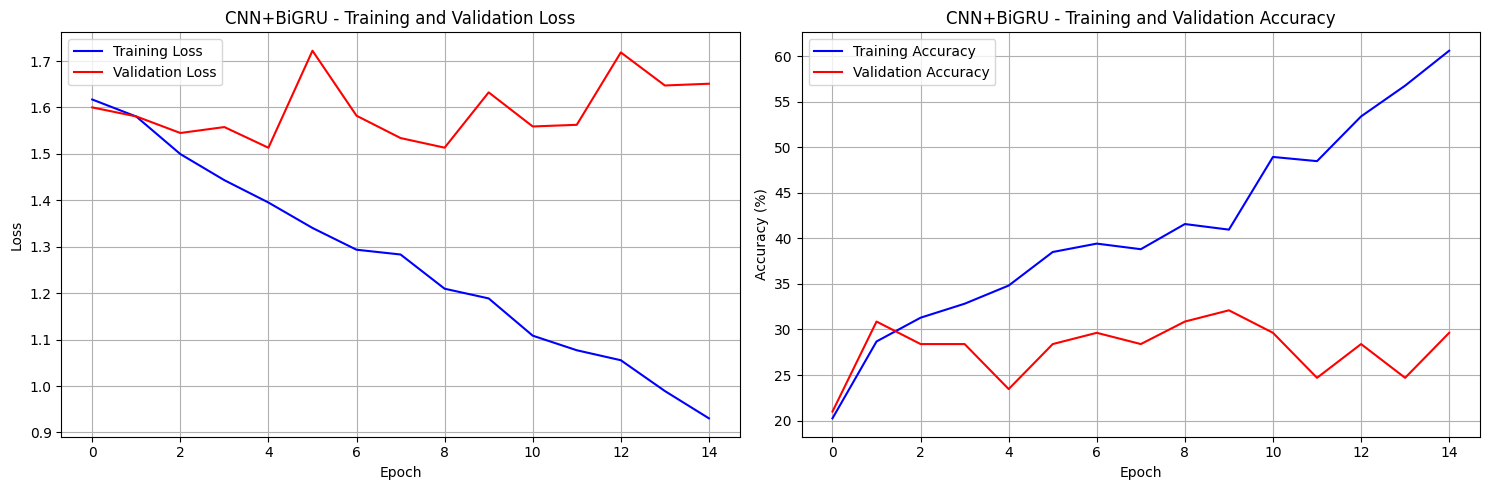

CNN+BiGRU model saved!


In [13]:
# === TRAIN MODEL 1: CNN + BiGRU ===
print("="*80)
print("TRAINING MODEL 1: CNN + BiGRU HYBRID")
print("="*80)

model1_trained, train_losses1, val_losses1, train_acc1, val_acc1 = train_model(
    model1, train_loader, val_loader, EPOCHS, "CNN+BiGRU"
)

# Plot training history for Model 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses1, label='Training Loss', color='blue')
ax1.plot(val_losses1, label='Validation Loss', color='red')
ax1.set_title('CNN+BiGRU - Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_acc1, label='Training Accuracy', color='blue')
ax2.plot(val_acc1, label='Validation Accuracy', color='red')
ax2.set_title('CNN+BiGRU - Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save Model 1
torch.save(model1_trained.state_dict(), 'cnn_bigru_model.pth')
print("CNN+BiGRU model saved!")

## Train Second Model

In [ ]:
# === TRAIN MODEL 2: VISION TRANSFORMER ===
print("="*80)
print("TRAINING MODEL 2: VISION TRANSFORMER")
print("="*80)

model2_trained, train_losses2, val_losses2, train_acc2, val_acc2 = train_model(
    model2, train_loader, val_loader, EPOCHS, "Vision Transformer"
)

# Plot training history for Model 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses2, label='Training Loss', color='blue')
ax1.plot(val_losses2, label='Validation Loss', color='red')
ax1.set_title('Vision Transformer - Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_acc2, label='Training Accuracy', color='blue')
ax2.plot(val_acc2, label='Validation Accuracy', color='red')
ax2.set_title('Vision Transformer - Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save Model 2
torch.save(model2_trained.state_dict(), 'vit_model.pth')
print("Vision Transformer model saved!")

TRAINING MODEL 2: VISION TRANSFORMER

Training Vision Transformer...
--------------------------------------------------
Epoch 1/15, Batch 0, Loss: 1.5670


## Evaluation and Results

In [ ]:
# === EVALUATE BOTH MODELS ===
print("="*50)
print("EVALUATING MODELS")
print("="*50)

# Evaluate Model 1
labels1, preds1, test_acc1 = evaluate_model(model1_trained, test_loader, "CNN+BiGRU")

# Evaluate Model 2
labels2, preds2, test_acc2 = evaluate_model(model2_trained, test_loader, "Vision Transformer")

# Store results for confusion matrix cells
all_labels = labels1  # Both models tested on same data
all_preds_model1 = preds1
all_preds_model2 = preds2

print(f"\nFINAL RESULTS:")
print(f"CNN+BiGRU Test Accuracy: {test_acc1:.2f}%")
print(f"Vision Transformer Test Accuracy: {test_acc2:.2f}%")

if test_acc2 > test_acc1:
    print(f"Vision Transformer performs better by {test_acc2-test_acc1:.2f}%")
    best_model = "Vision Transformer"
    all_preds = all_preds_model2  # Use best model for confusion matrix
elif test_acc1 > test_acc2:
    print(f"CNN+BiGRU performs better by {test_acc1-test_acc2:.2f}%")
    best_model = "CNN+BiGRU"
    all_preds = all_preds_model1  # Use best model for confusion matrix
else:
    print("Both models perform equally well!")
    best_model = "Tie"
    all_preds = all_preds_model1  # Use first model for confusion matrix

print(f"Best Model: {best_model}")

## Confusion Matrix

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# === CONFUSION MATRIX FOR BEST MODEL ===
cm_multi = confusion_matrix(all_labels, all_preds)
cm_multi_df = pd.DataFrame(cm_multi, index=classes, columns=classes)
print(f"\n{best_model} - Confusion Matrix:")
print(cm_multi_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{best_model} - Confusion Matrix')
plt.show()

# === CONFUSION MATRIX FOR BOTH MODELS COMPARISON ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# CNN+BiGRU Confusion Matrix
cm1 = confusion_matrix(all_labels, all_preds_model1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title(f'CNN+BiGRU - Confusion Matrix (Acc: {test_acc1:.2f}%)')

# Vision Transformer Confusion Matrix
cm2 = confusion_matrix(all_labels, all_preds_model2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds',
            xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Vision Transformer - Confusion Matrix (Acc: {test_acc2:.2f}%)')

plt.tight_layout()
plt.show()

## Classification Report

In [ ]:
# === CLASSIFICATION REPORT FOR BOTH MODELS ===

print("="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

# CNN+BiGRU Classification Report
print("\nCNN+BiGRU - Detailed Classification Report:")
print(classification_report(all_labels, all_preds_model1, target_names=classes))

# === CNN+BiGRU CLASS-WISE ACCURACY ===
cm1 = confusion_matrix(all_labels, all_preds_model1)
class_accuracy1 = cm1.diagonal() / cm1.sum(axis=1)
print("\nCNN+BiGRU - Class-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy1):
    print(f"{class_name}: {acc:.2%}")

# Vision Transformer Classification Report
print("\n" + "="*50)
print("Vision Transformer - Detailed Classification Report:")
print(classification_report(all_labels, all_preds_model2, target_names=classes))

# === Vision Transformer CLASS-WISE ACCURACY ===
cm2 = confusion_matrix(all_labels, all_preds_model2)
class_accuracy2 = cm2.diagonal() / cm2.sum(axis=1)
print("\nVision Transformer - Class-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy2):
    print(f"{class_name}: {acc:.2%}")

# === COMBINED METRICS REPORTS ===
print("\n" + "="*80)
print("COMBINED METRICS COMPARISON")
print("="*80)

# CNN+BiGRU Combined Report
report1 = classification_report(all_labels, all_preds_model1, target_names=classes, output_dict=True)
report1_df = pd.DataFrame(report1).transpose()
report1_df['accuracy'] = None
report1_df.loc[classes, 'accuracy'] = class_accuracy1

print("\nCNN+BiGRU - Combined Metrics Report:")
print(report1_df.round(4))

# Vision Transformer Combined Report
report2 = classification_report(all_labels, all_preds_model2, target_names=classes, output_dict=True)
report2_df = pd.DataFrame(report2).transpose()
report2_df['accuracy'] = None
report2_df.loc[classes, 'accuracy'] = class_accuracy2

print("\nVision Transformer - Combined Metrics Report:")
print(report2_df.round(4))

# Final comparison plot
models = ['CNN+BiGRU', 'Vision Transformer']
accuracies = [test_acc1, test_acc2]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Test Accuracy (%)')
plt.title('Model Performance Comparison')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"Models saved as 'cnn_bigru_model.pth' and 'vit_model.pth'")
print("All evaluation metrics have been generated and displayed.")